# Project: Wrangling and Analyze Data

In [552]:
import pandas as pd
import numpy as np
import requests as rq
import tweepy as tw
import json
import os
from itables import show
import matplotlib.pyplot as plt

## Data Gathering

1. Read the csv file shared by WeRateDogs tweeter account directly into a dataframe:

In [2]:
df_twArch = pd.read_csv('./input_data/twitter-archive-enhanced.csv')


2. Download the tweet image prediction (image_predictions.tsv) using the request library

In [3]:
url = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'
response = rq.get(url)
with open('./input_data/image-predictions.tsv', 'wb') as file:
    file.write(response.content)
    

In [5]:
# load the tsv file data into a dataframe

df_imgpred = pd.read_csv('./input_data/image-predictions.tsv', sep='\t' )

3. Use the Tweepy library to query additional data via the Twitter API (tweet_json.txt)

In [6]:
# Tweeter API can be queried using a code similar to this.
# I was not able to get access to tweeter developer account, because of tweeter new policies, therefore I wont be able to run the code and check its  validity fully!

auth = tw.OAuthHandler('xxx', 'xxx')
auth.set_access_token('xx-xxxx', 'xxx')
api = tw.API(auth, 
                 parser = tw.parsers.JSONParser(), 
                 wait_on_rate_limit = True) #, wait_on_rate_limit_notify = True) # works for new version of tweepy! my env don't have the required version.

# Use tweepy methods to download each tweet metrics

tweets_list = []
# If tweets are not found, capture them for any needed further analysis.
tweets_not_found = []

for tweet_id in df_twArch['tweet_id']:   
    try:
        tweets_list.append(api.get_status(tweet_id))
    except Exception as e:
        tweets_not_found.append(tweet_id)
    

In [7]:
# convert the list of dictinaries to a dataframe
df_twMetrics = pd.DataFrame(tweets_list, columns=['response'])

# use pandas dataframe methods to save json into a txt file without brackets []. each object is on its own line.
df_twMetrics.to_json('./input_data/tweet_json.txt', orient='records', lines=True)


In [9]:
# Read json file, and capture key
metrics_list = []
with open('./input_data/tweet-json.txt', 'r', encoding='utf-8') as file:
    for row in file:
        line = json.loads(row)
        tweet_id = line['id']
        favorite_count = line['favorite_count']
        retweet_count = line['retweet_count']
        followers_count = line['user']['followers_count']
        friends_count = line['user']['friends_count']
        tweet_text = line['full_text']
        text_url = tweet_text[tweet_text.find('https'):]
        source = line['source']
        source_text = source[source.find('rel="nofollow">') + 15:-4]
        retweeted_flag = line['retweeted']
        retweeted_status = 'original' if line.get('retweeted_status', 'original') == 'original' else 'retweet'
        metrics_list.append({'tweet_id': str(tweet_id),
                             'favorite_count': int(favorite_count),
                             'retweet_count': int(retweet_count),
                             'followers_count': int(followers_count),
                             'friends_count': int(friends_count),
                             'url': text_url,
                             'source': source_text,
                             'retweeted_flag': retweeted_flag,
                             'retweeted_status': retweeted_status,
                            })

df_twMetrics = pd.DataFrame(metrics_list, columns = ['tweet_id', 'favorite_count','retweet_count', 
                                                           'followers_count', 'friends_count','source', 'retweeted_flag',
                                                           'retweeted_status', 'url'])

In [706]:
# view files present in the data directory
os.listdir('./input_data')


['twitter-archive-enhanced.csv',
 'tweet-json.txt',
 '.ipynb_checkpoints',
 'image-predictions.tsv']

## Assessing Data


#### 1- Inspect df_twArch dataframe

In [8]:
# top 10 rows from the twitter archive dataframe
df_twArch.head(10)


,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None
5,891087950875897856,NaN,NaN,2017-07-29 00:08:17 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a majestic great white breaching ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891087950...,13,10,None,None,None,None,None
6,890971913173991426,NaN,NaN,2017-07-28 16:27:12 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Jax. He enjoys ice cream so much he gets ...,NaN,NaN,NaN,"https://gofundme.com/ydvmve-surgery-for-jax,ht...",13,10,Jax,None,None,None,None
7,890729181411237888,NaN,NaN,2017-07-28 00:22:40 +0000,"<a href=""http://twitter.com/download/iphone"" r...",When you watch your owner call another dog a g...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890729181...,13,10,None,None,None,None,None
8,890609185150312448,NaN,NaN,2017-07-27 16:25:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Zoey. She doesn't want to be one of th...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890609185...,13,10,Zoey,None,None,None,None
9,890240255349198849,NaN,NaN,2017-07-26 15:59:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Cassie. She is a college pup. Studying...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890240255...,14,10,Cassie,doggo,None,None,None


In [28]:
# bottom 10 rows of the tweets archieve dataframe
df_twArch.tail(10)


,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
2346,666058600524156928,NaN,NaN,2015-11-16 01:01:59 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here is the Rand Paul of retrievers folks! He'...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666058600...,8,10,the,None,None,None,None
2347,666057090499244032,NaN,NaN,2015-11-16 00:55:59 +0000,"<a href=""http://twitter.com/download/iphone"" r...",My oh my. This is a rare blond Canadian terrie...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666057090...,9,10,a,None,None,None,None
2348,666055525042405380,NaN,NaN,2015-11-16 00:49:46 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here is a Siberian heavily armored polar bear ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666055525...,10,10,a,None,None,None,None
2349,666051853826850816,NaN,NaN,2015-11-16 00:35:11 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is an odd dog. Hard on the outside but lo...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666051853...,2,10,an,None,None,None,None
2350,666050758794694657,NaN,NaN,2015-11-16 00:30:50 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a truly beautiful English Wilson Staff...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666050758...,10,10,a,None,None,None,None
2351,666049248165822465,NaN,NaN,2015-11-16 00:24:50 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a 1949 1st generation vulpix. Enj...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666049248...,5,10,None,None,None,None,None
2352,666044226329800704,NaN,NaN,2015-11-16 00:04:52 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a purebred Piers Morgan. Loves to Netf...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666044226...,6,10,a,None,None,None,None
2353,666033412701032449,NaN,NaN,2015-11-15 23:21:54 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here is a very happy pup. Big fan of well-main...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666033412...,9,10,a,None,None,None,None
2354,666029285002620928,NaN,NaN,2015-11-15 23:05:30 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a western brown Mitsubishi terrier. Up...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666029285...,7,10,a,None,None,None,None
2355,666020888022790149,NaN,NaN,2015-11-15 22:32:08 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a Japanese Irish Setter. Lost eye...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666020888...,8,10,None,None,None,None,None


In [10]:
# Use summary statistics to understand df_twArch dataframe
df_twArch.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2356 non-null   int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2356 non-null   object 
 4   source                      2356 non-null   object 
 5   text                        2356 non-null   object 
 6   retweeted_status_id         181 non-null    float64
 7   retweeted_status_user_id    181 non-null    float64
 8   retweeted_status_timestamp  181 non-null    object 
 9   expanded_urls               2297 non-null   object 
 10  rating_numerator            2356 non-null   int64  
 11  rating_denominator          2356 non-null   int64  
 12  name                        2356 non-null   object 
 13  doggo                       2356 

In [15]:
# Inspect values present in some columns
df_twArch['in_reply_to_status_id'].value_counts()


6.671522e+17    2
8.562860e+17    1
8.131273e+17    1
6.754971e+17    1
6.827884e+17    1
               ..
8.482121e+17    1
6.715449e+17    1
6.936422e+17    1
6.849598e+17    1
7.331095e+17    1
Name: in_reply_to_status_id, Length: 77, dtype: int64

In [16]:
df_twArch['in_reply_to_user_id'].value_counts()


4.196984e+09    47
2.195506e+07     2
7.305050e+17     1
2.916630e+07     1
3.105441e+09     1
2.918590e+08     1
2.792810e+08     1
2.319108e+09     1
1.806710e+08     1
3.058208e+07     1
2.625958e+07     1
1.943518e+08     1
3.589728e+08     1
8.405479e+17     1
2.894131e+09     1
2.143566e+07     1
2.281182e+09     1
1.648776e+07     1
4.717297e+09     1
2.878549e+07     1
1.582854e+09     1
4.670367e+08     1
4.738443e+07     1
1.361572e+07     1
1.584641e+07     1
2.068372e+07     1
1.637468e+07     1
1.185634e+07     1
1.198989e+09     1
1.132119e+08     1
7.759620e+07     1
Name: in_reply_to_user_id, dtype: int64

In [17]:
df_twArch['retweeted_status_id'].value_counts()


7.757333e+17    1
7.507196e+17    1
6.742918e+17    1
6.833919e+17    1
8.269587e+17    1
               ..
7.848260e+17    1
7.806013e+17    1
8.305833e+17    1
7.047611e+17    1
7.331095e+17    1
Name: retweeted_status_id, Length: 181, dtype: int64

In [18]:
df_twArch['source'].value_counts()


<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>     2221
<a href="http://vine.co" rel="nofollow">Vine - Make a Scene</a>                          91
<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>                       33
<a href="https://about.twitter.com/products/tweetdeck" rel="nofollow">TweetDeck</a>      11
Name: source, dtype: int64

In [27]:
# there are 745 dogs with 'None' assigned to name. Also there are 55 dogs with 'a' assigned to name!
df_twArch['name'].value_counts()


None         745
a             55
Charlie       12
Lucy          11
Oliver        11
            ... 
Ronnie         1
Bertson        1
Thor           1
Charleson      1
Ferg           1
Name: name, Length: 957, dtype: int64

In [22]:
# there are 97 dogs with type doggo
df_twArch['doggo'].value_counts()


None     2259
doggo      97
Name: doggo, dtype: int64

In [23]:
# there are 10 dogs with type floofer
df_twArch['floofer'].value_counts()


None       2346
floofer      10
Name: floofer, dtype: int64

In [24]:
# there are 257 dogs with type pupper
df_twArch['pupper'].value_counts()


None      2099
pupper     257
Name: pupper, dtype: int64

In [25]:
# there are 30 dogs with type puppo
df_twArch['puppo'].value_counts()


None     2326
puppo      30
Name: puppo, dtype: int64

In [61]:
# from above there are 97 + 10 + 257 + 30 = 394 instances of type assigned
# however there are 380 dogs with type assigned, this indicates that 14 dogs may have multiple dypes assigned at the same time!
df_type = df_twArch.query('doggo != "None" | floofer != "None" | pupper != "None" | puppo != "None"').copy(deep=True) 
df_type[['doggo','floofer','pupper','puppo']].shape


(380, 4)

In [65]:
# there are 14 rows where a dog type hold multiple values.
df_type['count'] = df_type[['doggo','floofer','pupper','puppo']].eq('None', axis=1).sum(axis=1)
df_type.query('count < 3').shape


(14, 18)

In [66]:
# let's examine these records of multiple dog types
df_type.query('count < 3')


,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,count
191,855851453814013952,NaN,NaN,2017-04-22 18:31:02 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here's a puppo participating in the #ScienceMa...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/855851453...,13,10,None,doggo,None,None,puppo,2
200,854010172552949760,NaN,NaN,2017-04-17 16:34:26 +0000,"<a href=""http://twitter.com/download/iphone"" r...","At first I thought this was a shy doggo, but i...",NaN,NaN,NaN,https://twitter.com/dog_rates/status/854010172...,11,10,None,doggo,floofer,None,None,2
460,817777686764523521,NaN,NaN,2017-01-07 16:59:28 +0000,"<a href=""http://twitter.com/download/iphone"" r...","This is Dido. She's playing the lead role in ""...",NaN,NaN,NaN,https://twitter.com/dog_rates/status/817777686...,13,10,Dido,doggo,None,pupper,None,2
531,808106460588765185,NaN,NaN,2016-12-12 00:29:28 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have Burke (pupper) and Dexter (doggo)...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/808106460...,12,10,None,doggo,None,pupper,None,2
565,802265048156610565,7.331095e+17,4.196984e+09,2016-11-25 21:37:47 +0000,"<a href=""http://twitter.com/download/iphone"" r...","Like doggo, like pupper version 2. Both 11/10 ...",NaN,NaN,NaN,https://twitter.com/dog_rates/status/802265048...,11,10,None,doggo,None,pupper,None,2
575,801115127852503040,NaN,NaN,2016-11-22 17:28:25 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Bones. He's being haunted by another d...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/801115127...,12,10,Bones,doggo,None,pupper,None,2
705,785639753186217984,NaN,NaN,2016-10-11 00:34:48 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Pinot. He's a sophisticated doggo. You...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/785639753...,10,10,Pinot,doggo,None,pupper,None,2
733,781308096455073793,NaN,NaN,2016-09-29 01:42:20 +0000,"<a href=""http://vine.co"" rel=""nofollow"">Vine -...","Pupper butt 1, Doggo 0. Both 12/10 https://t.c...",NaN,NaN,NaN,https://vine.co/v/5rgu2Law2ut,12,10,None,doggo,None,pupper,None,2
778,775898661951791106,NaN,NaN,2016-09-14 03:27:11 +0000,"<a href=""http://twitter.com/download/iphone"" r...","RT @dog_rates: Like father (doggo), like son (...",7.331095e+17,4.196984e+09,2016-05-19 01:38:16 +0000,https://twitter.com/dog_rates/status/733109485...,12,10,None,doggo,None,pupper,None,2
822,770093767776997377,NaN,NaN,2016-08-29 03:00:36 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is just downright precious...,7.410673e+17,4.196984e+09,2016-06-10 00:39:48 +0000,https://twitter.com/dog_rates/status/741067306...,12,10,just,doggo,None,pupper,None,2


In [80]:
# all timestamp values have one zone (midnight Greenwich time)
df_twArch[~df_twArch['timestamp'].str.contains('\+0000', na=False)]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo


#### 2- Inspect df_imgpred dataframe

In [11]:
# top 10 rows from the image prediciton dataframe
df_imgpred.head(10)


,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True
5,666050758794694657,https://pbs.twimg.com/media/CT5Jof1WUAEuVxN.jpg,1,Bernese_mountain_dog,0.651137,True,English_springer,0.263788,True,Greater_Swiss_Mountain_dog,0.016199,True
6,666051853826850816,https://pbs.twimg.com/media/CT5KoJ1WoAAJash.jpg,1,box_turtle,0.933012,False,mud_turtle,0.045885,False,terrapin,0.017885,False
7,666055525042405380,https://pbs.twimg.com/media/CT5N9tpXIAAifs1.jpg,1,chow,0.692517,True,Tibetan_mastiff,0.058279,True,fur_coat,0.054449,False
8,666057090499244032,https://pbs.twimg.com/media/CT5PY90WoAAQGLo.jpg,1,shopping_cart,0.962465,False,shopping_basket,0.014594,False,golden_retriever,0.007959,True
9,666058600524156928,https://pbs.twimg.com/media/CT5Qw94XAAA_2dP.jpg,1,miniature_poodle,0.201493,True,komondor,0.192305,True,soft-coated_wheaten_terrier,0.082086,True


In [12]:
# bottom 10 rows from the image prediction dataframe
df_imgpred.tail(10)


,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
2065,890240255349198849,https://pbs.twimg.com/media/DFrEyVuW0AAO3t9.jpg,1,Pembroke,0.511319,True,Cardigan,0.451038,True,Chihuahua,0.029248,True
2066,890609185150312448,https://pbs.twimg.com/media/DFwUU__XcAEpyXI.jpg,1,Irish_terrier,0.487574,True,Irish_setter,0.193054,True,Chesapeake_Bay_retriever,0.118184,True
2067,890729181411237888,https://pbs.twimg.com/media/DFyBahAVwAAhUTd.jpg,2,Pomeranian,0.566142,True,Eskimo_dog,0.178406,True,Pembroke,0.076507,True
2068,890971913173991426,https://pbs.twimg.com/media/DF1eOmZXUAALUcq.jpg,1,Appenzeller,0.341703,True,Border_collie,0.199287,True,ice_lolly,0.193548,False
2069,891087950875897856,https://pbs.twimg.com/media/DF3HwyEWsAABqE6.jpg,1,Chesapeake_Bay_retriever,0.425595,True,Irish_terrier,0.116317,True,Indian_elephant,0.076902,False
2070,891327558926688256,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,2,basset,0.555712,True,English_springer,0.225770,True,German_short-haired_pointer,0.175219,True
2071,891689557279858688,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,1,paper_towel,0.170278,False,Labrador_retriever,0.168086,True,spatula,0.040836,False
2072,891815181378084864,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,1,Chihuahua,0.716012,True,malamute,0.078253,True,kelpie,0.031379,True
2073,892177421306343426,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,1,Chihuahua,0.323581,True,Pekinese,0.090647,True,papillon,0.068957,True
2074,892420643555336193,https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg,1,orange,0.097049,False,bagel,0.085851,False,banana,0.076110,False


In [26]:
# Use summary statistics to understand df_imgpred dataframe
df_imgpred.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tweet_id  2075 non-null   int64  
 1   jpg_url   2075 non-null   object 
 2   img_num   2075 non-null   int64  
 3   p1        2075 non-null   object 
 4   p1_conf   2075 non-null   float64
 5   p1_dog    2075 non-null   bool   
 6   p2        2075 non-null   object 
 7   p2_conf   2075 non-null   float64
 8   p2_dog    2075 non-null   bool   
 9   p3        2075 non-null   object 
 10  p3_conf   2075 non-null   float64
 11  p3_dog    2075 non-null   bool   
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


#### 3- Inspect df_twMetrics dataframe

In [6]:
# top 10 rows from the tweets metrics dataframe
df_twMetrics.head(10)


,tweet_id,favorite_count,retweet_count
0,892420643555336193,39467,8853
1,892177421306343426,33819,6514
2,891815181378084864,25461,4328
3,891689557279858688,42908,8964
4,891327558926688256,41048,9774
5,891087950875897856,20562,3261
6,890971913173991426,12041,2158
7,890729181411237888,56848,16716
8,890609185150312448,28226,4429
9,890240255349198849,32467,7711


In [13]:
# bottom 10 rows from the tweets metrics dataframe
df_twMetrics.tail(10)


,tweet_id,favorite_count,retweet_count
2344,666058600524156928,115,61
2345,666057090499244032,304,146
2346,666055525042405380,448,261
2347,666051853826850816,1253,879
2348,666050758794694657,136,60
2349,666049248165822465,111,41
2350,666044226329800704,311,147
2351,666033412701032449,128,47
2352,666029285002620928,132,48
2353,666020888022790149,2535,532


In [20]:
# Use summary statistics to understand df_twMetrics dataframe
df_twMetrics.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2354 entries, 0 to 2353
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   tweet_id          2354 non-null   object
 1   favorite_count    2354 non-null   int64 
 2   retweet_count     2354 non-null   int64 
 3   followers_count   2354 non-null   int64 
 4   friends_count     2354 non-null   int64 
 5   source            2354 non-null   object
 6   retweeted_flag    2354 non-null   bool  
 7   retweeted_status  2354 non-null   object
 8   url               2354 non-null   object
dtypes: bool(1), int64(4), object(4)
memory usage: 149.5+ KB


### Quality issues

1. Timestamp needs splitting to date and time

2. Clean 'None' from doggo, floofer, pupper, puppo columns and join to a new column name dog_type.

3. Clean HTML code and extract hyperlink text in the source column

4. Resolve erronous string values such as 'None' and 'a' from Dog names column

5. Remove non-dog images based on p1, and remove 2nd and 3rd prediction columns as they are not required

6. Convert confidance to % with 2 decimal precision points

7. Extract file name from jpg_url

8. Remove underscores _ and convert breed name into proper capitalised English names and rename column to breed. 

### Tidiness issues

9. Remove retweets from observations (rows of data) and also remove retweets related columns

10. The data is split into 3 different dataframes, which need to be merged to produce a master dataframe for analysis 

## Cleaning Data
In this section, clean **all** of the issues you documented while assessing. 

**Note:** Make a copy of the original data before cleaning. Cleaning includes merging individual pieces of data according to the rules of [tidy data](https://cran.r-project.org/web/packages/tidyr/vignettes/tidy-data.html). The result should be a high-quality and tidy master pandas DataFrame (or DataFrames, if appropriate).

In [628]:
# Make copies of original data frames
dfa_copy = df_twArch.copy(deep=True)
dfp_copy = df_imgpred.copy(deep=True)
dfm_copy = df_twMetrics.copy(deep=True)


### Issue #1: Timestamp needs splitting to date and time

#### Define:

The timestamp is currently in this format: 2015-11-16 01:01:59 +0000, which encapulates the date, the time, and the timezone offset. timezone is always +0000, which is midnight Greenwich time.

We need to be able to separate those three fields, which allows us to analyse those pieces separately with ease. Therefore, we will create two columns one for date and one for time.

#### Code

In [629]:
# timestamp is a string type
type(dfa_copy['timestamp'][0])

str

In [630]:
# convert timestamp string to datetime object to work with.
dfa_copy['timestamp'] = pd.to_datetime(dfa_copy['timestamp'], format='%Y-%m-%d %H:%M:%S %z')
# Extract date and time from timestamp
dfa_copy['date'] = pd.to_datetime(dfa_copy['timestamp']).dt.date
dfa_copy['year'] = pd.to_datetime(dfa_copy['timestamp']).dt.year
dfa_copy['month'] = pd.to_datetime(dfa_copy['timestamp']).dt.month
dfa_copy['day'] = pd.to_datetime(dfa_copy['timestamp']).dt.day
dfa_copy['weekday_name'] = pd.to_datetime(dfa_copy['timestamp']).dt.day_name()
dfa_copy['time'] = pd.to_datetime(dfa_copy['timestamp']).dt.time
dfa_copy['hour'] = pd.to_datetime(dfa_copy['timestamp']).dt.hour
dfa_copy['minute'] = pd.to_datetime(dfa_copy['timestamp']).dt.minute
dfa_copy['second'] = pd.to_datetime(dfa_copy['timestamp']).dt.second


#### Test

In [631]:
# Check if errors produced during conversion
dfa_copy['timestamp'].isna().sum()

0

In [632]:
# Check conversion values
dfa_copy['timestamp'].head(5)

0   2017-08-01 16:23:56+00:00
1   2017-08-01 00:17:27+00:00
2   2017-07-31 00:18:03+00:00
3   2017-07-30 15:58:51+00:00
4   2017-07-29 16:00:24+00:00
Name: timestamp, dtype: datetime64[ns, UTC]

In [633]:
# Check if any errors were produced during conversion
dfa_copy['date'].isna().sum(), dfa_copy['time'].isna().sum()

(0, 0)

In [634]:
# inspect conversion worked on top 5 records
dfa_copy[['date','year','month','day','weekday_name','time','hour','minute', 'second']].head(5)

,date,year,month,day,weekday_name,time,hour,minute,second
0,2017-08-01,2017,8,1,Tuesday,16:23:56,16,23,56
1,2017-08-01,2017,8,1,Tuesday,00:17:27,0,17,27
2,2017-07-31,2017,7,31,Monday,00:18:03,0,18,3
3,2017-07-30,2017,7,30,Sunday,15:58:51,15,58,51
4,2017-07-29,2017,7,29,Saturday,16:00:24,16,0,24


In [635]:
# Finally we could drop the no longer required columns. But I prefer to keep the original timestamp for any downstream 
# systems that require a ready to use timestamp! depends on whether you want to use this clean data for other systems!
# dfa_copy.drop(['timestamp'], axis=1, inplace=True)

### Issue #2: Remove 'None', and 'a' values and combine dog type

#### Define
'None' was used when no values are present. This is not ideal as it can be treated as valid value when carring out analysis on those columns. Also, the name 'a' for Dogs was used 51 times which is wrong and likely to present a none present value.

Also doggo, floofer, pupper, puppo columns represent dog types, which is unefficient and uneasy to analyse. It is best to combine the columns into one dog type column that can be used for further analysis such as filtering, and segmentation.

#### Code

In [636]:
# None is a string and not python type None.
dfa_copy['doggo'][0], type(dfa_copy['doggo'][0])


('None', str)

In [637]:
# replace 'None' strings with proper None type value
dfa_copy.replace({'None': None}, inplace=True)


In [638]:
# Combine type columns into one column
dfa_copy[['type']] = dfa_copy[['doggo','floofer','pupper','puppo']].apply(lambda x: '|'.join(filter(None,list(x))) , axis=1)
# filter(None,list(x))
# '|'.join([str(i) for i in x if i is not None]

In [639]:
# convert empty string values into NaN so that out of the box python packages can handle properly for filtering
dfa_copy['type'].replace({'':np.nan}, inplace=True)

#### Test

In [640]:
# Check empty strings are not present in the column values
dfa_copy.query('type == ""').head(5)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,...,date,year,month,day,weekday_name,time,hour,minute,second,type


In [641]:
# Check type values from conversion produced correctly
dfa_copy.query('~type.isnull()').head(5)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,...,date,year,month,day,weekday_name,time,hour,minute,second,type
9,890240255349198849,NaN,NaN,2017-07-26 15:59:51+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Cassie. She is a college pup. Studying...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890240255...,...,2017-07-26,2017,7,26,Wednesday,15:59:51,15,59,51,doggo
12,889665388333682689,NaN,NaN,2017-07-25 01:55:32+00:00,"<a href=""http://twitter.com/download/iphone"" r...",Here's a puppo that seems to be on the fence a...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/889665388...,...,2017-07-25,2017,7,25,Tuesday,01:55:32,1,55,32,puppo
14,889531135344209921,NaN,NaN,2017-07-24 17:02:04+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Stuart. He's sporting his favorite fan...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/889531135...,...,2017-07-24,2017,7,24,Monday,17:02:04,17,2,4,puppo
29,886366144734445568,NaN,NaN,2017-07-15 23:25:31+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Roscoe. Another pupper fallen victim t...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/886366144...,...,2017-07-15,2017,7,15,Saturday,23:25:31,23,25,31,pupper
43,884162670584377345,NaN,NaN,2017-07-09 21:29:42+00:00,"<a href=""http://twitter.com/download/iphone"" r...",Meet Yogi. He doesn't have any important dog m...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/884162670...,...,2017-07-09,2017,7,9,Sunday,21:29:42,21,29,42,doggo


In [642]:
# check NaN conversion for empty strings worked well
dfa_copy[dfa_copy['type'].isna()].head(5)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,...,date,year,month,day,weekday_name,time,hour,minute,second,type
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,...,2017-08-01,2017,8,1,Tuesday,16:23:56,16,23,56,NaN
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,...,2017-08-01,2017,8,1,Tuesday,00:17:27,0,17,27,NaN
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,...,2017-07-31,2017,7,31,Monday,00:18:03,0,18,3,NaN
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,...,2017-07-30,2017,7,30,Sunday,15:58:51,15,58,51,NaN
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,...,2017-07-29,2017,7,29,Saturday,16:00:24,16,0,24,NaN


In [643]:
# inspect values where there are multiple types assigned identified by the joining character |
dfa_copy.query('~type.isnull()').query('type.str.contains("\|")').head(5)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,...,date,year,month,day,weekday_name,time,hour,minute,second,type
191,855851453814013952,NaN,NaN,2017-04-22 18:31:02+00:00,"<a href=""http://twitter.com/download/iphone"" r...",Here's a puppo participating in the #ScienceMa...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/855851453...,...,2017-04-22,2017,4,22,Saturday,18:31:02,18,31,2,doggo|puppo
200,854010172552949760,NaN,NaN,2017-04-17 16:34:26+00:00,"<a href=""http://twitter.com/download/iphone"" r...","At first I thought this was a shy doggo, but i...",NaN,NaN,NaN,https://twitter.com/dog_rates/status/854010172...,...,2017-04-17,2017,4,17,Monday,16:34:26,16,34,26,doggo|floofer
460,817777686764523521,NaN,NaN,2017-01-07 16:59:28+00:00,"<a href=""http://twitter.com/download/iphone"" r...","This is Dido. She's playing the lead role in ""...",NaN,NaN,NaN,https://twitter.com/dog_rates/status/817777686...,...,2017-01-07,2017,1,7,Saturday,16:59:28,16,59,28,doggo|pupper
531,808106460588765185,NaN,NaN,2016-12-12 00:29:28+00:00,"<a href=""http://twitter.com/download/iphone"" r...",Here we have Burke (pupper) and Dexter (doggo)...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/808106460...,...,2016-12-12,2016,12,12,Monday,00:29:28,0,29,28,doggo|pupper
565,802265048156610565,7.331095e+17,4.196984e+09,2016-11-25 21:37:47+00:00,"<a href=""http://twitter.com/download/iphone"" r...","Like doggo, like pupper version 2. Both 11/10 ...",NaN,NaN,NaN,https://twitter.com/dog_rates/status/802265048...,...,2016-11-25,2016,11,25,Friday,21:37:47,21,37,47,doggo|pupper


In [644]:
# the 14 records where dogs are assigned multiple types identified by the joining character |
dfa_copy.query('~type.isnull()').query('type.str.contains("\|")')['type'].count()

14

In [645]:
# Finally drop the no longer required columns
dfa_copy.drop(['doggo','floofer','pupper','puppo'], axis=1, inplace=True)

### Issue #3: Clean HTML code and extract hyperlink text in the source column

#### Define
The source column includes the entire html code of the url. These code fragments are not required and instead we just need the source captured in the hyperlink text.

#### Code

In [646]:
# inspect first value format
dfa_copy['source'][0]

'<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>'

In [647]:
# replace 'None' strings with proper None type value
def strip_text(x):
    start_index = x.find(">")
    end_index = x.find("</", start_index)
    return x[start_index+1:end_index]
    
dfa_copy['source_text'] = dfa_copy['source'].apply(lambda x: strip_text(x))

In [648]:
# Combine type columns into one column
x = dfa_copy['source'][0]
start_index = x.find(">")
end_index = x.find("</", start_index)
x[start_index+1:end_index]

'Twitter for iPhone'

#### Test

In [649]:
# Check if NA is produced in the conversion process
dfa_copy['source_text'].isna().sum()

0

In [650]:
# Check values correctness
dfa_copy[['source','source_text']].value_counts()

source                                                                               source_text        
<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>   Twitter for iPhone     2221
<a href="http://vine.co" rel="nofollow">Vine - Make a Scene</a>                      Vine - Make a Scene      91
<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>                   Twitter Web Client       33
<a href="https://about.twitter.com/products/tweetdeck" rel="nofollow">TweetDeck</a>  TweetDeck                11
dtype: int64

In [651]:
# Finally drop the no longer required columns
dfa_copy.drop(['source'], axis=1, inplace=True)

In [652]:
# Remove the reminder of url columns, given that we don't have time to clean them now, and also they don't seem to hold 
# lots of valuable data anyway.
dfa_copy.drop(['expanded_urls'], axis=1, inplace=True)

In [653]:
# Remove the reminder of url columns, given that we don't have time to clean them now, and also they don't seem to hold 
# lots of valuable data anyway.
dfm_copy.drop(['url'], axis=1, inplace=True)

### Issue #4: Resolve erronous string values such as 'None' and 'a' from Dog names column

#### Define
The name column contains the string value 'None' which needs to be converted to python NAN so that it is filtered or kept using the built-in methods in python data analysis and visulisations packages.
Also, the name column contains the string value 'a' which also seems to be a quick input added when no name is present. This value also needs to be converted to python NAN so that it is filtered using the built-in methods in python data analysis and visulisations packages.

#### Code

In [654]:
# Replace 'None' and 'a' with python NAN
dfa_copy['name'].replace({'None': np.nan,'a':np.nan}, inplace=True)

#### Test

In [655]:
# Check column value with count
dfa_copy['name'].value_counts()

Charlie    12
Cooper     11
Lucy       11
Oliver     11
Tucker     10
           ..
Harvey      1
Brat        1
Grady       1
Mojo        1
Ferg        1
Name: name, Length: 955, dtype: int64

In [656]:
# Check NAN value are present
dfa_copy['name'].isna().sum()

800

In [657]:
# Check that no 'None' or 'a' string values are present anymore in the column
dfa_copy.query('(name == "None") | (name == "a")')['name'].count()

0

### Issue #5: Remove non-dog images based on p1, and remove 2nd and 3rd prediction columns as they are not required

#### Define
There are three predictions supplied for each image, which can be useful for prediction model validation. However, for our purposes we would need to filter out non-dog values based  on the first prediciton and also remove the other two predictions from the dataframe.

#### Code

In [658]:
# Filter out non-dog tweets base don p1_dog value
dfp_copy = dfp_copy[dfp_copy.p1_dog]

#### Test

In [659]:
# print dataframe to check values
dfp_copy

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True
...,...,...,...,...,...,...,...,...,...,...,...,...
2068,890971913173991426,https://pbs.twimg.com/media/DF1eOmZXUAALUcq.jpg,1,Appenzeller,0.341703,True,Border_collie,0.199287,True,ice_lolly,0.193548,False
2069,891087950875897856,https://pbs.twimg.com/media/DF3HwyEWsAABqE6.jpg,1,Chesapeake_Bay_retriever,0.425595,True,Irish_terrier,0.116317,True,Indian_elephant,0.076902,False
2070,891327558926688256,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,2,basset,0.555712,True,English_springer,0.225770,True,German_short-haired_pointer,0.175219,True
2072,891815181378084864,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,1,Chihuahua,0.716012,True,malamute,0.078253,True,kelpie,0.031379,True


In [660]:
# There are no values that are predicted to be not a dog
dfp_copy.query('p1_dog == False')['p1_dog'].count()

0

In [661]:
# Finally drop the no longer required columns
dfp_copy.drop(['p1_dog','p2','p2_conf','p2_dog','p3','p3_conf','p3_dog'], axis=1, inplace=True)

### Issue #6:  Convert confidence to % with 2 decimal precision points

#### Define
Confidence values are in 6 decimal precision values. They are bit hard to read and interpret. It would be easier to conver those to a percentage formated values with 2 precision digits

#### Code

In [662]:
# None is a string and not python type None.
dfp_copy['p1_conf'] = dfp_copy['p1_conf'].apply(lambda x: "{0:.2f}%".format(round(x*100,2)))

#### Test

In [663]:
# print column values
dfp_copy['p1_conf']

0       46.51%
1       50.68%
2       59.65%
3       40.81%
4       56.03%
         ...  
2068    34.17%
2069    42.56%
2070    55.57%
2072    71.60%
2073    32.36%
Name: p1_conf, Length: 1532, dtype: object

In [664]:
# Check no conversion errors were produced
dfp_copy['p1_conf'].isna().sum()

0

In [665]:
# rename column
dfp_copy.rename(columns={'p1_conf': 'confidence'}, inplace=True)

### Issue #7: Extract file name from jpg_url

#### Define
The source column includes the entire html code of the url. These code fragments are not required and instead we just need the source captured in the hyperlink text.

#### Code

In [666]:
# None is a string and not python type None.
dfp_copy['jpg_name'] = dfp_copy.jpg_url.str.split("/").str.get(-1)

#### Test

In [667]:
# print top type values
dfp_copy['jpg_name']

0       CT4udn0WwAA0aMy.jpg
1       CT42GRgUYAA5iDo.jpg
2       CT4521TWwAEvMyu.jpg
3       CT5Dr8HUEAA-lEu.jpg
4       CT5IQmsXIAAKY4A.jpg
               ...         
2068    DF1eOmZXUAALUcq.jpg
2069    DF3HwyEWsAABqE6.jpg
2070    DF6hr6BUMAAzZgT.jpg
2072    DGBdLU1WsAANxJ9.jpg
2073    DGGmoV4XsAAUL6n.jpg
Name: jpg_name, Length: 1532, dtype: object

In [668]:
# Check there are no errors produced durig conversion
dfp_copy['jpg_name'].isna().sum()

0

In [669]:
# Finally drop the no longer required columns
dfp_copy.drop(['jpg_url'], axis=1, inplace=True)

### Issue #8: Remove underscores _ and convert breed name into proper capitalised English names and rename column to breed.

#### Define
The dog breed names needs to have the _ removed from text and namea are Camel case capitalised so it reads well in English.

#### Code

In [670]:
# None is a string and not python type None.
dfp_copy['breed'] = dfp_copy['p1'].apply(lambda x: x.replace("_", " ").title())

#### Test

In [671]:
# print top type values
dfp_copy['breed'].value_counts()

Golden Retriever      150
Labrador Retriever    100
Pembroke               89
Chihuahua              83
Pug                    57
                     ... 
Entlebucher             1
Clumber                 1
Scotch Terrier          1
Standard Schnauzer      1
Japanese Spaniel        1
Name: breed, Length: 111, dtype: int64

In [672]:
# Check there are no errors produced durig conversion
dfp_copy['breed'].isna().sum()

0

In [673]:
# Finally drop the no longer required columns
dfp_copy.drop(['p1'], axis=1, inplace=True)

### Issue #9: Remove retweets from observations (rows of data) and also remove retweet related columns

#### Define
We are only interested in original tweets and scores from those tweets. Retweets could inflate the statistical measures. Therefore, we want to remove retweets related rows and also remove columns related to retweets.

#### Code

In [674]:
# Check NaN values are ture NaN type values 
np.isnan(dfa_copy['retweeted_status_id'][1])

True

In [675]:
# Select rows where ertweeted_status_id is NaN and does not hold a retweet status id. These should be original tweets.
dfa_copy = dfa_copy[dfa_copy['retweeted_status_id'].isna()]

#### Test

In [676]:
# Check the number retweets from original dataframe
df_twArch[df_twArch['retweeted_status_id'].isna()].shape

(2175, 17)

In [677]:
# Check the number of original tweets from original dataframe
df_twArch[df_twArch['retweeted_status_id'].notna()].shape

(181, 17)

In [678]:
# Check total number of rows from original dataframe
df_twArch['retweeted_status_id'].shape

(2356,)

In [679]:
# Verify dropping retweets (retweeted_status_id is not NaN) actually worked
dfa_copy['retweeted_status_id'].notna().sum()

0

In [680]:
# Verify number of remaining rows matches the tweets number from orginal 
dfa_copy['retweeted_status_id'].isna().sum()

2175

In [681]:
# empty values as all are NaN.
dfa_copy['retweeted_status_id'].value_counts()

Series([], Name: retweeted_status_id, dtype: int64)

In [682]:
# Finally drop the no longer required columns
dfa_copy.drop(['retweeted_status_id','retweeted_status_user_id','retweeted_status_timestamp'], axis=1, inplace=True)

### Issue #10: combine the 3 dataframes into one for ease of analysis, 

#### Define
Each of the 3 dataframe holds different set of data. It would very useful to combine the 3 dataframe to a master dataframe where all metrics are and dimensions are available for analysis.

Create a dataframe from the shared tweets ids and drop any unmatched tweets ids across the dataframes. Otherwise you end up with a dataframe that has lots of rows with incomplete variables.

#### Code

In [683]:
# Check NaN values are ture NaN type values 
dfa_copy.shape,dfp_copy.shape,dfm_copy.shape

((2175, 19), (1532, 5), (2354, 8))

In [684]:
# Check there are no duplicate tweet_id keys in dataframes, so that merge can be done cleanly
dfa_copy['tweet_id'].duplicated().value_counts()

False    2175
Name: tweet_id, dtype: int64

In [685]:
# Check there are no duplicate tweet_id keys in dataframes, so that merge can be done cleanly
dfp_copy['tweet_id'].duplicated().value_counts()

False    1532
Name: tweet_id, dtype: int64

In [686]:
# Check there are no duplicate tweet_id keys in dataframes, so that merge can be done cleanly
dfm_copy['tweet_id'].duplicated().value_counts()

False    2354
Name: tweet_id, dtype: int64

In [687]:
# Check tweet_id is in the dame type across dataframe so that merge can be done easily
type(dfa_copy['tweet_id'][0])

numpy.int64

In [688]:
# Check tweet_id is in the dame type across dataframe so that merge can be done easily
type(dfp_copy['tweet_id'][0])

numpy.int64

In [689]:
# Check tweet_id is in the dame type across dataframe so that merge can be done easily
type(dfm_copy['tweet_id'][0])

str

In [690]:
# convert tweets_ids to strings to join on easily with dfm_copy. String format is preferred as it stop tweet_is treated
# as numbers and converted or altered in any future operations.
dfa_copy['tweet_id']= dfa_copy['tweet_id'].astype(str)
dfp_copy['tweet_id']= dfp_copy['tweet_id'].astype(str)

In [691]:
# Remove duplicate column found in dfm_copy and dfa_copy
dfm_copy.drop(['source'], axis=1, inplace=True) 

In [692]:
# merge the 3 dataframes, using inner join
df_master = dfa_copy.merge(dfp_copy,on='tweet_id').merge(dfm_copy,on='tweet_id')

#### Test

In [693]:
# Check the number for retweeted_status_id is NaN from original dataframe
df_master.head(5)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,text,rating_numerator,rating_denominator,name,date,year,...,img_num,confidence,jpg_name,breed,favorite_count,retweet_count,followers_count,friends_count,retweeted_flag,retweeted_status
0,892177421306343426,NaN,NaN,2017-08-01 00:17:27+00:00,This is Tilly. She's just checking pup on you....,13,10,Tilly,2017-08-01,2017,...,1,32.36%,DGGmoV4XsAAUL6n.jpg,Chihuahua,33819,6514,3200889,104,False,original
1,891815181378084864,NaN,NaN,2017-07-31 00:18:03+00:00,This is Archie. He is a rare Norwegian Pouncin...,12,10,Archie,2017-07-31,2017,...,1,71.60%,DGBdLU1WsAANxJ9.jpg,Chihuahua,25461,4328,3200889,104,False,original
2,891327558926688256,NaN,NaN,2017-07-29 16:00:24+00:00,This is Franklin. He would like you to stop ca...,12,10,Franklin,2017-07-29,2017,...,2,55.57%,DF6hr6BUMAAzZgT.jpg,Basset,41048,9774,3200889,104,False,original
3,891087950875897856,NaN,NaN,2017-07-29 00:08:17+00:00,Here we have a majestic great white breaching ...,13,10,None,2017-07-29,2017,...,1,42.56%,DF3HwyEWsAABqE6.jpg,Chesapeake Bay Retriever,20562,3261,3200889,104,False,original
4,890971913173991426,NaN,NaN,2017-07-28 16:27:12+00:00,Meet Jax. He enjoys ice cream so much he gets ...,13,10,Jax,2017-07-28,2017,...,1,34.17%,DF1eOmZXUAALUcq.jpg,Appenzeller,12041,2158,3200889,104,False,original


In [694]:
# double confirm no retweets are found
df_master.query('retweeted_status != "original"')['retweeted_status'].count()

0

In [695]:
# double confirm no retweets are found
df_master.query('retweeted_flag == True')['retweeted_flag'].count()

0

In [696]:
# 1477 records are produced from the inner join step.
df_master.shape

(1477, 29)

## Storing Data


In [707]:
# Save clean dataframe into csv to a file named: "twitter_archive_master.csv"
df_master.to_csv('./input_data/twitter_archive_master.csv', sep=',', encoding='utf-8')

## Analyzing and Visualizing Data

In [708]:
# Read data from the master file if you don't have it loaded:
df_master = pd.read_csv('./input_data/twitter_archive_master.csv')

In [709]:
# The 10 most popular dog names
# dog names were cleaned by removing the string values 'None' and 'a' and replace them with np.nan, otherwise they would have 
# appeared in the list below. The cleaning work we did earlier gave us an immediate clean list of dog names. 
df_master['name'].value_counts().head(10)

Charlie    10
Cooper     10
Oliver      9
Tucker      8
Lucy        8
Sadie       7
Penny       7
Daisy       7
Jax         6
Koda        6
Name: name, dtype: int64

In [699]:
# The 10 most popular dog types
# dog types were cleaned by removing the string value 'None' and replacing them with np.nan, otherwise they would have 
# appeared in the list below. Also, by combining the different columns in one column allows to easily in one line to
# obtain a clean list of dog names.
df_master['type'].value_counts().head(10)

pupper           144
doggo             48
puppo             19
doggo|pupper       8
floofer            7
doggo|floofer      1
doggo|puppo        1
Name: type, dtype: int64

In [700]:
# The 10 most popular dog breeds
# dog breed column was cleaned by removing "_" and capitalising English names, which made the list much neater and easier
# to read as we can see below.
df_master['breed'].value_counts().head(10)

Golden Retriever      139
Labrador Retriever     95
Pembroke               88
Chihuahua              79
Pug                    54
Chow                   41
Samoyed                40
Pomeranian             38
Toy Poodle             38
Malamute               29
Name: breed, dtype: int64

### Insights:
1. Charlie, and Coppere are the most popular dog names

2. Pupper is by far the most dog type

3. Golden Retriever is by far the most popular dog breed

### Visualization

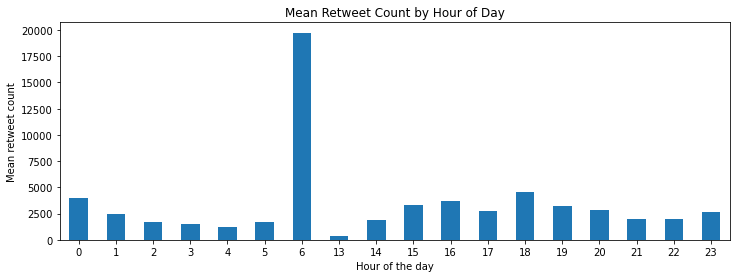

In [715]:
# 6 am is by far the most popular time for tweeting about dog rating

# Having extracted the time data from the timestamp string
fig, axs = plt.subplots(figsize=(12, 4))

df_master.groupby(df_master["hour"])["retweet_count"].mean().plot(
    kind='bar', rot=0, ax=axs)

plt.xlabel("Hour of the day");  # custom x label using Matplotlib

plt.ylabel("Mean retweet count");

plt.title("Mean Retweet Count by Hour of Day")

plt.savefig('./img/retweet-count-viz.png')
plt.show()

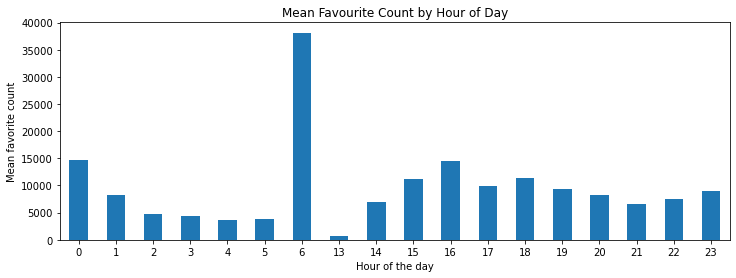

In [728]:
# 6 am is by far the most popular time for favoring dog tweets.

fig, axs = plt.subplots(figsize=(12, 4))

df_master.groupby(df_master["hour"])["favorite_count"].mean().plot(
    kind='bar', rot=0, ax=axs)

plt.xlabel("Hour of the day");  # custom x label using Matplotlib

plt.ylabel("Mean favorite count");

plt.title("Mean Favourite Count by Hour of Day");

plt.savefig('./img/favorite-count-viz.png')
plt.show()

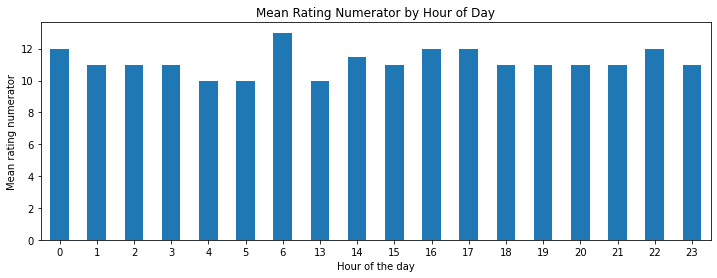

In [713]:
# 6 am is the time where the highest average rating is given to dogs.

# note: had I had time to clean the rating denominators and rating numerator, the plot below would have been much simplier and 
# I would have not had to resolve to using the quantile for removing outliers. none the less, here is the plot
# This is a good example of how cleaning data before hand makes easier to wrangle, plot, and work with!

q_lo = df_master["rating_numerator"].quantile(0.01)
q_hi = df_master["rating_numerator"].quantile(0.99)

fig, axs = plt.subplots(figsize=(12, 4))

df_master.query('(rating_denominator) == 10 & (rating_numerator > @q_lo) &(rating_numerator < @q_hi)').groupby(df_master["hour"])["rating_numerator"].median().plot(
    kind='bar', rot=0, ax=axs)

plt.xlabel("Hour of the day");  # custom x label using Matplotlib

plt.ylabel("Mean rating numerator");

plt.title("Mean Rating Numerator by Hour of Day");

plt.savefig('./img/rating-numerator-viz.png')
plt.show()

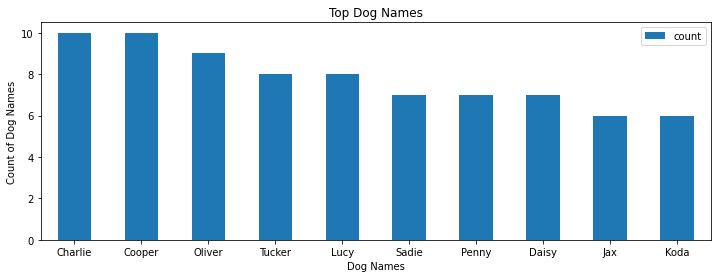

In [732]:
# top Dog Names

df_temp = df_master['name'].value_counts().head(10).reset_index()
df_temp.rename(columns={'index': 'name', 'name': 'count'}, inplace=True)

fig, axs = plt.subplots(figsize=(12, 4))

df_temp.plot(x='name', y='count', kind='bar', rot=0, ax=axs)

plt.xlabel("Dog Names");  # custom x label using Matplotlib

plt.ylabel("Count of Dog Names");

plt.title("Top Dog Names");

plt.savefig('./img/Dog-names-count-viz.png')
plt.show()

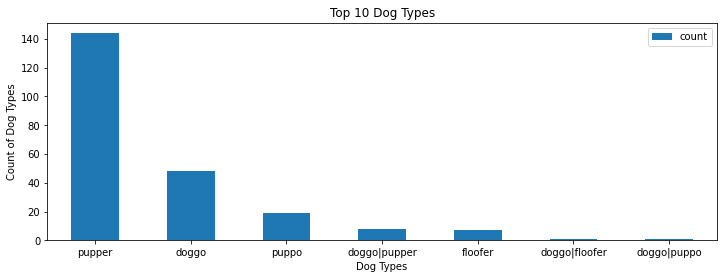

In [730]:
# top Dog Names

df_temp = df_master['type'].value_counts().head(10).reset_index()
df_temp.rename(columns={'index': 'type', 'type': 'count'}, inplace=True)

fig, axs = plt.subplots(figsize=(12, 4))

df_temp.plot(x='type', y='count', kind='bar', rot=0, ax=axs)

plt.xlabel("Dog Types");  # custom x label using Matplotlib

plt.ylabel("Count of Dog Types");

plt.title("Top 10 Dog Types");

plt.savefig('./img/Dog-types-count-viz.png')
plt.show()

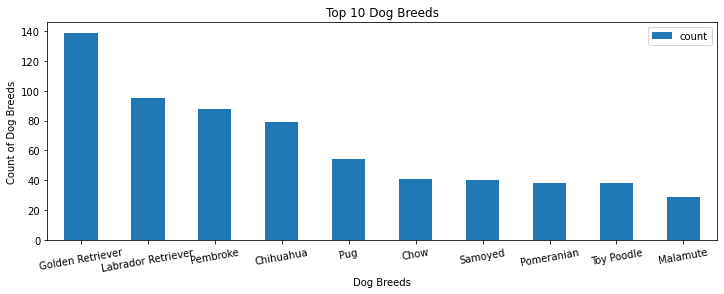

In [735]:
# top Dog Names

df_temp = df_master['breed'].value_counts().head(10).reset_index()
df_temp.rename(columns={'index': 'breed', 'breed': 'count'}, inplace=True)

fig, axs = plt.subplots(figsize=(12, 4))

df_temp.plot(x='breed', y='count', kind='bar', rot=0, ax=axs)

plt.xlabel("Dog Breeds");  # custom x label using Matplotlib

plt.ylabel("Count of Dog Breeds");

plt.title("Top 10 Dog Breeds");

plt.xticks(rotation=10)

plt.savefig('./img/Dog-breed-count-viz.png')
plt.show()